In [12]:
import os
import os.path
from PIL import Image
import numpy as np
import pandas as pd

from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [18]:
DATASET_PATH = './archive'

IMAGES_PATH = DATASET_PATH +'/img_align_celeba/img_align_celeba'
RESIZED_PATH = IMAGES_PATH + "/" + "resized"

METADATA_PATH = DATASET_PATH +'/list_attr_celeba.csv'
SPLIT_PATH = DATASET_PATH +'/list_eval_partition.csv'

MODEL_PATH = "100ep_200k_v2/cp.h5"

NB_SELECTED = 202599
excluded_labels = ["Arched_Eyebrows","Attractive","Blurry","Double_Chin","Narrow_Eyes"]

In [8]:
def resize(dir_path):
    cnt = 0
    for file in os.listdir(dir_path):
        image_path = dir_path + "/" + file
        try :
            img = Image.open(image_path) 
            img = img.resize((224,224))
            
            if not os.path.exists(RESIZED_PATH):
                os.makedirs(RESIZED_PATH)
    
            img.save(RESIZED_PATH+"/"+file)
            Image.close(image_path)
            cnt += 1
        except :
            images.pop()
            print("erreur",file)

    print("Resize of " + cnt + "images done !")

In [9]:
def list_images(dir_path):
    images = []
    for file in os.listdir(dir_path):
        images.append(file)
    return images

In [16]:
images = list_images(DATASET_PATH + "/resized")

In [19]:
df_old = pd.read_csv(METADATA_PATH)
split_df = pd.read_csv(SPLIT_PATH)
part = [0 if i<(NB_SELECTED*0.7) else (1 if (i>=(NB_SELECTED*0.7) and i<NB_SELECTED*0.8) else 2) for i in range(NB_SELECTED)]
split_df = pd.DataFrame(data={'image_path':images, split_df.columns[1]:part},
               columns =['image_path', split_df.columns[1]])

y = []
for row in df_old.iterrows():
    sub_y = []
    for i in range(1,len(row[1])) :
        if (int(row[1][i])==1) and (df_old.columns.values[i] not in excluded_labels):
            sub_y.append(df_old.columns.values[i])
    y.append(sub_y)
    
df = pd.DataFrame(list(zip(list(df_old[df_old.columns[0]]), y)),
               columns =['image_path', 'tags'])



result = pd.merge(split_df, df,on='image_path')

training_df = result.loc[result['partition']==0]
validation_df = result.loc[result['partition']==1]
testing_df = result.loc[result['partition']==2]

KeyboardInterrupt: 

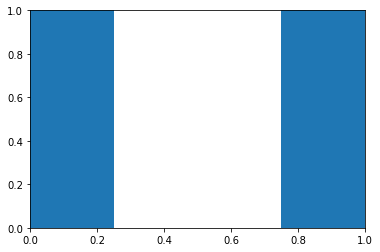

In [46]:
testing_df['tags'].value_counts().plot.bar()

In [22]:
all_labels = [] 
for labels in training_df['tags'].values.tolist():
    for label in labels:
        all_labels.append(label)
        
unique_labels = list(np.unique(all_labels))

In [24]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


# In[16]:


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


# In[36]:


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r))

In [37]:
testing_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
testing_generator = testing_data_generator.flow_from_dataframe(dataframe=testing_df,
                                                               directory=DATASET_PATH + "/resized",
                                                               x_col='image_path',
                                                               y_col='tags',
                                                               batch_size=16,
                                                               seed=115,
                                                               shuffle=False,
                                                               class_mode="categorical",
                                                               target_size=(224, 224))

Found 40519 validated image filenames belonging to 35 classes.


In [25]:
print("Récupération du modèle")
model = load_model(MODEL_PATH, custom_objects={"f1": f1, "recall": recall,"precision": precision}, compile=True)

Récupération du modèle


In [40]:
model.evaluate(
    x=testing_generator,
    batch_size=testing_generator.batch_size,
    return_dict=True,
    steps=testing_generator.n // testing_generator.batch_size
)


2532/2532 [==============================] - 587s 231ms/step - loss: 0.3653 - accuracy: 0.0351 - recall: 0.5478 - precision: 0.6862 - f1: 0.6078


{'loss': 0.36528894305229187,
 'accuracy': 0.03507602587342262,
 'recall': 0.547762393951416,
 'precision': 0.6862133741378784,
 'f1': 0.6077584624290466}

In [41]:
print("debut prediction")
predictions = model.predict(testing_generator,
                              steps=testing_generator.n // testing_generator.batch_size,
                              verbose=1)
print("fin prediction")

debut prediction
2532/2532 [==============================] - 564s 223ms/step
fin prediction


In [42]:
images_path = []
predicted_titles = []
pred_labels = []

seuil_confiance = 40


for prediction_index, prediction in enumerate(predictions):
    predicted_title = []
    for i in range(len(prediction)):
        if prediction[i]*100 >seuil_confiance :
            predicted_title.append(unique_labels[i] + " %.1f" % (prediction[i]*100) + "%")
            pred_labels.append(unique_labels[i])
    images_path.append(testing_generator.filenames[prediction_index])
    predicted_titles.append(predicted_title)

In [43]:
def difference(index) : 
    line = df_old.loc[df_old['image_id'] == images_path[index]]
    sub_y = []
    for i in line.columns[1:] :
        sub_y.append(line[i].values[0])
    
    pred_y = [-1]*len(sub_y)
    for j in range(len(unique_labels)) :
        if unique_labels[j] in pred_labels[index]:
            pred_y[j] = 1
            
    drop_features = []
    correctness = 0
    for i in range(len(unique_labels)) :
        if sub_y[i] == pred_y[i]:
            correctness += 1
            drop_features.append(0)
        else :
            drop_features.append(1)
            
    correctness = correctness*100 / len(pred_y)
    return correctness, drop_features

In [44]:
accuracy = 0
drop_features = {j:0 for j in unique_labels}


for i in range(len(images_path)):
    test = difference(i)
    for feat in range(len(test[1])):
        drop_features[unique_labels[feat]]+=test[1][feat]
    accuracy += test[0]

KeyboardInterrupt: 

In [ ]:
print("Proximité moyenne avec les labels réels : ",accuracy/len(images_path),"%")
print("Labels et le nombre de fois où ils étaient faux : ", dict(sorted(drop_features.items(), key=lambda item: item[1], reverse=True)))

In [ ]:

f = "test"
for files in os.listdir(f):
    f_img = f+"/"+files
    img = Image.open(f_img)
    img = img.resize((224,224))
    img.save(f_img)
print("Images resized !")
 


predictions =  []
images_path = []
labels_images = []
best_labels = []
seuil_confiance = 40
for file in os.listdir(f):
    f_img = f+"/"+file

    #load image
    my_image = load_img(f_img, target_size=(224, 224))
    #preprocess the image
    my_image = img_to_array(my_image)
    my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
    my_image = preprocess_input(my_image)

    #make the prediction<br>
    pred_values = model.predict(my_image)
    predictions.append(pred_values)
    images_path.append(file)

    #enregistre les meilleurs labels
    best = []
    labels = []

    for i in range(len(pred_values[0])):
        if pred_values[0][i]*100 > seuil_confiance :
            best.append(unique_labels[i] + " %.1f" % (pred_values[0][i]*100) + "%")
        labels.append(unique_labels[i] + " %.1f" % (pred_values[0][i]*100) + "%"

    best_labels.append(best)
    labels_images.append(labels)


for image in range(len(images_path)):
    print(images_path[image])
    print("Best labels : ")
    print(best_labels[image])